# Fermi limits with Sommerfeld enhancement

In [115]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import scipy.integrate as integrate

At freeze-out, we want
$$
\langle \sigma v \rangle _{relic} = \frac{\pi \alpha^2}{M^2} S_{FO} = \frac{\pi \alpha^2}{M^2} 2\pi \frac{\alpha}{v} \frac{1}{1- e^{-2\pi \alpha / v}}
$$
where $\langle 1/ v_{rel} \rangle=4$ at freeze-out. We also know that $\langle \sigma v \rangle _{relic} = 4.4\times 10^{-26} \mathrm{cm}^3 \mathrm{s}^{-1}$ for our model with non-self-conjugate DM. In reference [13], which is the paper about Fermi limits, they use self-conjugate DM, therefore we will have to weaken the limits by a factor of 2. We want to use the equation above to derive $\alpha(M)$ that reproduces the correct relic abundance, but the equation does not have an analytic solution. Below I solve it numerically.

In [116]:
sigmav_conversion = 1.52 * 10 ** 24 / (5.06 * 10 ** 13) ** 3 # Converts from GeV^-2 to cm^3s^-1
sigmav_relic = 4.4 * 10**(-26) # cm^-3s^-1
sigmav_relic_GeV = sigmav_relic / sigmav_conversion # GeV^-2

avg_vrel_FO = 1 / 4 # in units of c

vdisp_dSph = 10 / 300000 # 10 km/s in units of c
avg_vrel_dSph = 4 * vdisp_dSph / np.sqrt(np.pi) # in units of c

def MB(vrel, vdisp):
	return 1 / np.sqrt(4 * np.pi) * vrel**2 / vdisp**3 * np.exp(-vrel**2 / (4 * vdisp**2))

def S(alpha, vrel):
	coefficient = 2 * np.pi * alpha / vrel
	return coefficient / (1 - np.exp(-coefficient))

def avgS_single(alpha):
	integrand = lambda vrel : MB(vrel, vdisp_dSph) * S(alpha, vrel)
	integral, _ = integrate.quad(integrand, 0, avg_vrel_dSph * 4)
	return integral

avgS = np.vectorize(avgS_single)

def alpha_single(M):
	equation_to_solve = lambda alpha : sigmav_relic_GeV - np.pi * alpha ** 2 / M ** 2 * S(alpha, avg_vrel_FO)
	return opt.fsolve(equation_to_solve, 0.1)[0]

alpha = np.vectorize(alpha_single)

def simple_alpha(M):
	return M * np.sqrt(sigmav_relic_GeV / np.pi)

Below I'm plotting the dependence of $\alpha$ on $M$ with this new equation, and I'm comparing it to the one I found in excercise 3.3 which was just a linear dependence.

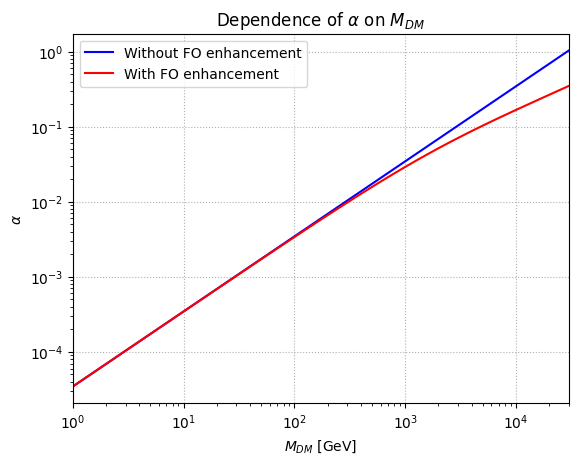

In [117]:
plt.title("Dependence of $\\alpha$ on $M_{DM}$")
plt.xlabel("$M_{DM}$ [GeV]")
plt.ylabel("$\\alpha$")
plt.xscale("log")
plt.yscale("log")
plt.grid(linestyle=':')
plt.margins(x=0)
M_axis = np.logspace(0, np.log10(30000))
plt.plot(M_axis, M_axis * np.sqrt(sigmav_relic_GeV / np.pi), color="blue", label="Without FO enhancement");
plt.plot(M_axis, alpha(M_axis), color="red", label="With FO enhancement");
plt.legend();

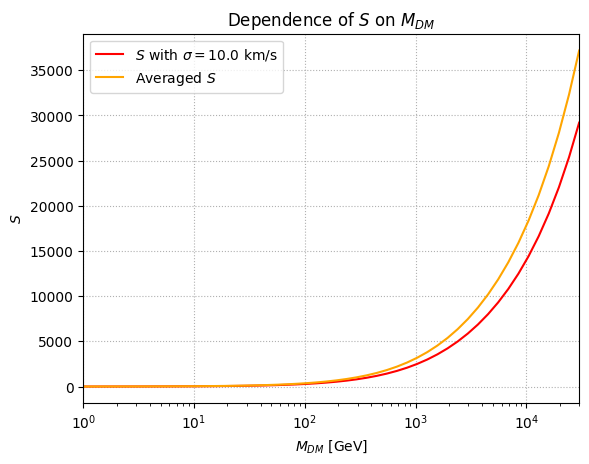

In [118]:
plt.title("Dependence of $S$ on $M_{DM}$")
plt.xlabel("$M_{DM}$ [GeV]")
plt.ylabel("$S$")
plt.xscale("log")
plt.grid(linestyle=':')
plt.margins(x=0)
plt.plot(M_axis, S(alpha(M_axis), avg_vrel_dSph), color="red", label="$S$ with $\\sigma=$" + str(vdisp_dSph * 300000) + " km/s");
plt.plot(M_axis, avgS(alpha(M_axis)), color="orange", label="Averaged $S$");
plt.legend();

I now use the result from the previous equation to calculate the enhanced cross-section relevant for the Fermi limits today. From the literature, I gathered that $v \simeq 10 \mathrm{km}/\mathrm{s}$ in dwarf spheroidal galaxies, which are the object of study of the Fermi collaboration. The enhanced cross-section is
$$
\langle \sigma v \rangle _{dSph} = \frac{\pi \alpha^2}{M^2} S_{dSph} = \frac{\pi \alpha^2}{M^2} 2\pi \frac{\alpha}{v} \frac{1}{1- e^{-2\pi \alpha / v}}
$$

In [119]:
def sigmav_now(M):
	a = alpha(M)
	return sigmav_conversion * np.pi * a ** 2 / M ** 2 * S(a, avg_vrel_dSph)

def simple_sigmav(M):
	return sigmav_conversion * np.pi * simple_alpha(M) ** 2 / M ** 2

In [120]:
import csv

M = []
sigma = []
with open('fermi-data.csv', 'r') as f:
	reader = csv.reader(f)
	next(reader)  # skip header

	for row in reader:
		if row:  # skip empty rows
			M.append(float(row[0]))
			sigma.append(float(row[1]) * 10**(-26))

	M = np.array(M)
	sigma = np.array(sigma)

In [121]:
def fit_func(M, K, M0, a, b):
	return K * (M / M0) ** (-a - b * np.log(M / M0))

popt, pcov = opt.curve_fit(fit_func, M, sigma * 2, p0=[10**(-26), 1, 1, -1])

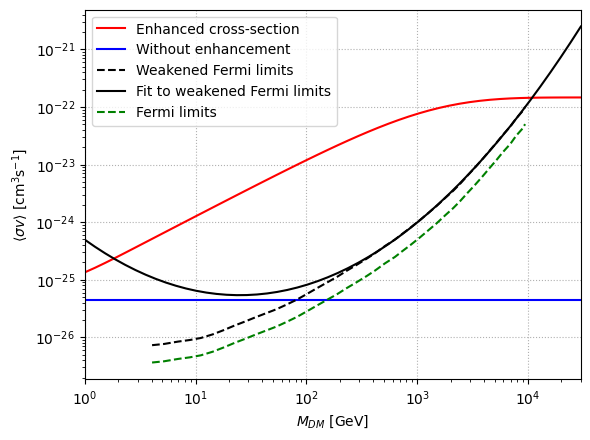

In [122]:
plt.xlabel("$M_{DM}$ [GeV]")
plt.ylabel("$\\langle \\sigma v \\rangle \\ [\\mathrm{cm}^3\\mathrm{s}^{-1}]$")
plt.xscale("log")
plt.yscale("log")
plt.margins(x=0)
plt.grid(linestyle=':')
plt.plot(M_axis, sigmav_now(M_axis), color="red", label="Enhanced cross-section");
plt.plot(M_axis, simple_sigmav(M_axis), color="blue", label="Without enhancement");
plt.plot(M, sigma * 2, '--', color="black", label="Weakened Fermi limits");
plt.plot(M_axis, fit_func(M_axis, *popt), color="black", label="Fit to weakened Fermi limits");
plt.plot(M, sigma, '--', color="green", label="Fermi limits");
plt.legend();

In [123]:
indices_above = np.where(sigma * 2 > sigmav_relic)[0]
index = indices_above[0]

print(f"Without Sommerfeld enhancement, prediction and limits meet at M={M[index]:.2f}GeV")

Without Sommerfeld enhancement, prediction and limits meet at M=82.14GeV


In [124]:
sol = opt.fsolve(lambda x: fit_func(x, *popt) - sigmav_now(x), 10**4)[0]
print(f"With Sommerfeld enhancement, prediction and limits meet at M={sol / 1000:.2f}TeV.")

With Sommerfeld enhancement, prediction and limits meet at M=10.91TeV.


It appears to me that no constraint can be put on $M$, as the enhanced cross-section is always above the dSph $4\tau$ graph for the range taken into consideration ($1-10^4\mathrm{GeV}$).